<a href="https://colab.research.google.com/github/Dots11/DavesProjects/blob/master/04_Transfer_Learning_in_Tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning with Tensorflow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.
There are two main benefits:

1. Can leverage an existing neural network atchitecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [ ]:
#Are we using a gpu?
!nvidia-smi

Sun Aug 21 17:20:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Downloading and becoming one with the data

In [ ]:
# Get data (10% of 10 food classes from Food 101)
import zipfile

# Download the storage

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()


--2022-08-21 17:20:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   297MB/s    in 0.5s    

2022-08-21 17:20:29 (297 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk thorugh 10 parcent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

As you can see above, we only have 10% of the training data we had before.

##Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` calss to load in our images in batches.

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(directory=train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode= "categorical")
print("Testing Images")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing Images
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Call backs are extra funcitonality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

Create a TensorBoard callback (functionized because we need to create a new one for each model)

In [ ]:
# Create a TensorBoard callback (functionized because we need to create a new one for each model)

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-^H%M%S") # the log_dir is the path of the directory where to save the log files that are to be parsed by TensorBoard
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir) # we already created log_dir
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

**Note:** You can customize the directory where your tensorBoard logs (model training metrics) get saved to whever you like. The `log_dir`parameter we've created above is only one option.

## Creating a model using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: Efficentnet https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
and Resnet https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5

In [ ]:
# Let's compare the following two models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Imoport dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):

  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential mdoel with it.

  Args:
    model_url (str): a TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
    should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extraction_layer = hub.KerasLayer(model_url,
                                           trainable = False, # set false, the feature_extraction_layer is not trainable during training
                                           name = "Feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE + (3,)) # freeze the already learned patterns
  # Create our own model
  model = tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes, activation="softmax", name = "output_layer")
  ]) 

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# Create ResNet model
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [ ]:
# Compile our resnet model
resnet_model.compile(loss ="categorical_crossentropy",
                     optimizer= tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (K  (None, 1001)             25615849  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 25,625,869
Trainable params: 10,020
Non-trainable params: 25,615,849
_________________________________________________________________


In [ ]:
# Fit our ResNet model to our augmented data of 10 food classes

resnet_history = resnet_model.fit(train_data_10_percent, epochs = 5, steps_per_epoch = len(train_data_10_percent), validation_data = test_data, validation_steps = len(test_data), callbacks=[create_tensorboard_callback(dir_name = "tensorflow_hub", experiment_name = "resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220821-^H2045
Epoch 1/5
24/24 [==============================] - 32s 717ms/step - loss: 2.4105 - accuracy: 0.3093 - val_loss: 1.2725 - val_accuracy: 0.5784
Epoch 2/5
24/24 [==============================] - 15s 629ms/step - loss: 0.9830 - accuracy: 0.6880 - val_loss: 0.9286 - val_accuracy: 0.6836
Epoch 3/5
24/24 [==============================] - 14s 600ms/step - loss: 0.6915 - accuracy: 0.7800 - val_loss: 0.8262 - val_accuracy: 0.7172
Epoch 4/5
24/24 [==============================] - 14s 616ms/step - loss: 0.5402 - accuracy: 0.8347 - val_loss: 0.8074 - val_accuracy: 0.7280
Epoch 5/5
24/24 [==============================] - 15s 629ms/step - loss: 0.4604 - accuracy: 0.8640 - val_loss: 0.7699 - val_accuracy: 0.7428


Incredible! Outperformed all our models built by hand, in quicker training AND with 10% of training examples.


In [ ]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it if you need it

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) # how many epochs did we run for?

  # Plot loss
  plt.figure() # create a separate plot for loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure() # create a separate plot for accuracy
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accurary")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()


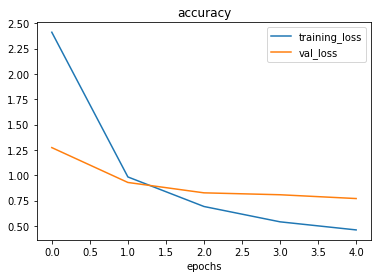

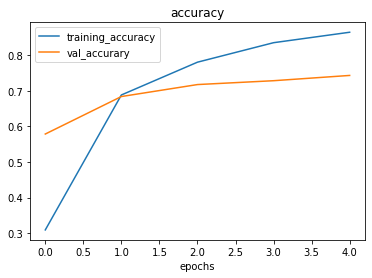

In [ ]:
# Plot our resnet_model
plot_loss_curves(resnet_history)

###Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
# Create Efficientnet model
efficientnet_model = create_model(efficientnet_url, num_classes = train_data_10_percent.num_classes)


In [ ]:
# Compile our model
efficientnet_model.compile(loss = "categorical_crossentropy",
                       optimizer = tf.keras.optimizers.Adam(),
                       metrics = ["accuracy"])

In [ ]:
# Fit our model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, epochs = 5, steps_per_epoch = len(train_data_10_percent), validation_data = test_data, validation_steps = len(test_data), callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name = "efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20220821-^H2227
Epoch 1/5
24/24 [==============================] - 25s 658ms/step - loss: 1.8038 - accuracy: 0.4600 - val_loss: 1.2684 - val_accuracy: 0.7176
Epoch 2/5
24/24 [==============================] - 15s 628ms/step - loss: 1.0471 - accuracy: 0.7600 - val_loss: 0.8528 - val_accuracy: 0.8128
Epoch 3/5
24/24 [==============================] - 14s 619ms/step - loss: 0.7578 - accuracy: 0.8387 - val_loss: 0.6887 - val_accuracy: 0.8396
Epoch 4/5
24/24 [==============================] - 15s 624ms/step - loss: 0.6117 - accuracy: 0.8627 - val_loss: 0.6077 - val_accuracy: 0.8488
Epoch 5/5
24/24 [==============================] - 15s 632ms/step - loss: 0.5155 - accuracy: 0.8813 - val_loss: 0.5542 - val_accuracy: 0.8588


In [ ]:
# Summary of our effientnet model

efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


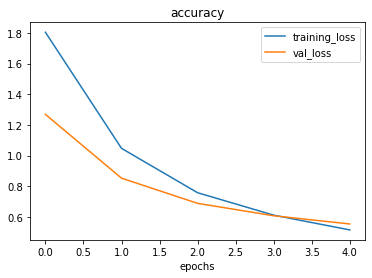

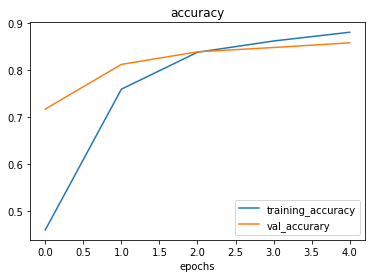

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
# How many layers does our effientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights) # 'weights' is another term for pattern, are used interchangeably

# Very powerful, since there are 309 layers below, saves us creating models by hand

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes whatsoever (e.g. using ImageNet model on 1000 ImageNet classes, none of your own).
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new layers)

## Comparing our model's results using TensorBoard

**Note:** When you upload things to TensorBoard.dev, you experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev.

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=EM2xP5forBswyXQZEg6sDwL65N1mes&prompt=consent&access_type=off

Our TensorFlow experiments are uploaded publically here: https://tensorboard.dev/experiment/yWfY9bczT2KVKLo2J3JMJA/

In [ ]:
# Check out hwat tensorflow experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/yWfY9bczT2KVKLo2J3JMJA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   yWfY9bczT2KVKLo2J3JMJA
	Created              2022-08-21 17:26:01 (35 minutes ago)
	Updated              2022-08-21 17:26:05 (35 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5812630
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
#!tensorboard dev delete --experiment_id yWfY9bczT2KVKLo2J3JMJA

In [ ]:
# Confirm the deletion by re-checking what experiments you have left
!tensorboard dev list

https://tensorboard.dev/experiment/yWfY9bczT2KVKLo2J3JMJA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   yWfY9bczT2KVKLo2J3JMJA
	Created              2022-08-21 17:26:01 (52 minutes ago)
	Updated              2022-08-21 17:26:05 (51 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5812630
Total: 1 experiment(s)


##**Challenge:** Create a binary image classification dataset (with 10 images of any two classes, e.g. car vs. truck) and use a pre-trained TensorFlow Hub image classification model to classify them.

In [ ]:
# Challenge: Binary image classificaiotn dataset (using pizza steak)
# Get data 
import zipfile

# Download the storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

#Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2022-08-21 20:10:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip.3’

pizza_steak.zip.3   100%[===================>] 104.47M   309MB/s    in 0.3s    

2022-08-21 20:10:52 (309 MB/s) - ‘pizza_steak.zip.3’ saved [109540975/109540975]



In [ ]:
# Create a TensorBoard callback (functionized because we need to create a new one for each model)

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-^H%M%S") # the log_dir is the path of the directory where to save the log files that are to be parsed by TensorBoard
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir) # we already created log_dir
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
# Select data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "pizza_steak/train/" 
test_dir = "pizza_steak/test/"

train_datagen = ImageDataGenerator(rescale=1./255.) 
test_datagen = ImageDataGenerator(rescale=1./255.)

print("Training Images")
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                              target_size = IMAGE_SHAPE,
                                              batch_size = BATCH_SIZE,
                                              class_mode = "binary")
print("Testing Images")
test_data = test_datagen.flow_from_directory(directory = test_dir,
                                                target_size = IMAGE_SHAPE,
                                                batch_size = BATCH_SIZE,
                                                class_mode = "binary")

Training Images
Found 1500 images belonging to 2 classes.
Testing Images
Found 500 images belonging to 2 classes.


In [ ]:
# Url containing model from TensorFlow Hub BiT-ResNet50x1
distill50_url = "https://tfhub.dev/sayakpaul/distill_bit_r50x1_224_feature_extraction/1"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=2):

  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential mdoel with it.

  Args:
    model_url (str): a TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
    should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extraction_layer = hub.KerasLayer(model_url,
                                           trainable = False, # set false, the feature_extraction_layer is not trainable during training
                                           name = "Feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE + (3,)) # freeze the already learned patterns
  # Create our own model
  model = tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes, activation="sigmoid", name = "output_layer")
  ]) 

  return model

In [ ]:
# Create distilr50 model
distill50_model = create_model(distill50_url, num_classes = train_data.num_classes)

distill50_model.compile(loss = "SparseCategoricalCrossentropy",
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics = ["accuracy"])

distill50_history = distill50_model.fit(train_data, epochs=5, steps_per_epoch = len(train_data), validation_data = test_data, validation_steps = len(test_data), callbacks=[create_tensorboard_callback(dir_name = "tensorflow_hub", experiment_name = "distill50_pizza_steak")])

Saving TensorBoard log files to: tensorflow_hub/distill50_pizza_steak/20220821-^H1414
Epoch 1/5
47/47 [==============================] - 34s 258ms/step - loss: 0.3493 - accuracy: 0.9187 - val_loss: 0.1447 - val_accuracy: 0.9960
Epoch 2/5
47/47 [==============================] - 11s 226ms/step - loss: 0.1395 - accuracy: 0.9700 - val_loss: 0.0767 - val_accuracy: 0.9960
Epoch 3/5
47/47 [==============================] - 11s 225ms/step - loss: 0.0941 - accuracy: 0.9780 - val_loss: 0.0530 - val_accuracy: 0.9980
Epoch 4/5
47/47 [==============================] - 11s 225ms/step - loss: 0.0736 - accuracy: 0.9860 - val_loss: 0.0416 - val_accuracy: 0.9980
Epoch 5/5
47/47 [==============================] - 11s 225ms/step - loss: 0.0623 - accuracy: 0.9873 - val_loss: 0.0345 - val_accuracy: 0.9980


In [ ]:
distill50_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (K  (None, 2048)             23500352  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 2)                 4098      
                                                                 
Total params: 23,504,450
Trainable params: 4,098
Non-trainable params: 23,500,352
_________________________________________________________________


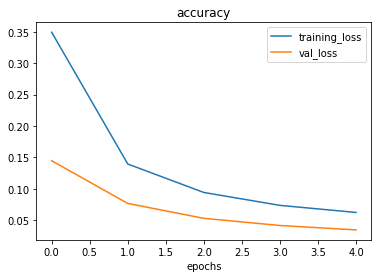

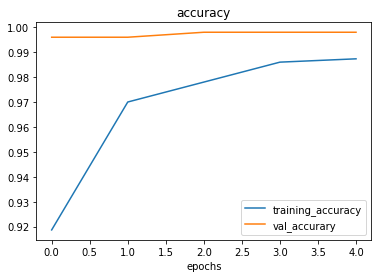

In [ ]:
plot_loss_curves(distill50_history)